# Fandango's Inflated Movie Ratings

In 2015, Walt Hickey investigated Fandango for what turned out to be inflated movie ratings. He wrote about his process and findings in a [FiveThirtyEight](https://fivethirtyeight.com/features/fandango-movies-ratings/) article. Hickey compared the ratings of films on Fandango to ratings on other popular aggregate review sites. He found that the Fandango ratings were consistently higher than the other sites, and that the other sites' ratings were all comparable with each other. At that time, the real Fandango rating (which was different than its displayed star rating) was in the HTML for the page. Hickey compared the real and displayed ratings and found egregious rounding issues that led to the discrepancy between Fandango's and other sites' ratings.

It's been nearly 5 years since the FiveThirtyEight piece was published, and we want to know: is Fandango still up to the same shenanigans, or did they fix what they claimed was a bug in their system? The actual rating values are no longer displayed in the pages' HTML, so we don't immediately know how the scores are rounded. We will investigate if there has been any change in what was five years ago a problematic and dishonest rating system.

---

We'll be comparing the [data Hickey used](https://github.com/fivethirtyeight/data/tree/master/fandango), pulled in August 2015, to data for movies released in the following two years, [pulled March 2017](https://github.com/mircealex/Movie_ratings_2016_17).

In [1]:
# Import the pandas library.
import pandas as pd

# Avoid truncating display
pd.options.display.max_columns = 100

# Read in the raw data used in Hickey's previous analysis and explore.
inflated = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/fandango/fandango_score_comparison.csv')
inflated.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,3.20,4.05,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,1.10,2.35,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,1.45,1.70,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [2]:
# Read in the 2017 data from after the article was published.
new = pd.read_csv('https://raw.githubusercontent.com/mircealex/Movie_ratings_2016_17/master/movie_ratings_16_17.csv')
new.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [3]:
# Limit analysis to Fandango.
inflated_fandango = ['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']
new_fandango = ['movie', 'year', 'fandango']

# Use copies to avoid later SettingWithCopyWarnings.
inflated_f = inflated[inflated_fandango].copy()
new_f = new[new_fandango].copy()

In [4]:
# Extract the years from the films in the old data set.
years = inflated_f['FILM'].str.extract(r'(\d\d\d\d)')
# Return the years included in the old data set.
print(years[0].unique())

['2015' '2014']


Hickey's data set contained every film that was rated on all the major review sites and had at least 30 user reviews on Fandango. From exploring that data, we know it includes only films released in 2014 and 2015.

The documentation for our more recent data set specifies that it only includes films released in 2016 and 2017 that had significant numbers of votes. It doesn't say what was the threshold number of votes for being included in the data set. A quick search on Fandango's site for some of the movies in this set reveals that Fandango currently only displays ratings from Rotten Tomatoes (another popular movie review aggregator).

The films included in both data sets were not sampled at random but rather chosen because of their popularity (significant number of ratings) and their release years (the two years prior to when data was collected) - one set before Hickey's analysis, the other after his published article.

While we'd like to work with data for all films in Fandango's database, we're limited to popular movies (and their trends) present in 2014/15 (pre-analysis) and 2016/17 (post-analysis). We'll use these samples to determine whether there's a difference in how Fandango rated and displayed movie ratings for popular movies in these time frames. This goal will serve as a useful proxy for determining whether there was a change in Fandango's system for rating all movies after Hickey's analysis.

---

### Is our post-article data set comparable to our pre-article data set?

To better understand the numbers of ratings that went into the later data set, we can take a random sample of movies and look up their vote numbers. This information doesn't currently exist on the [Fandango](fandango.com) site, but we can use the [wayback machine](archive.org). This is quite a tedious workaround, but it could provide some valuable information.

Here's the workflow:
* Take a random sample of the movies using `pd.sample()`.
* Look up the release date of each movie.
* Load the archive for fandango.com for the release dates.
* Click on the movie thumbnail to see the number of ratings.

In [5]:
# Take a random sample of movies from the newer data set to check.
verify = new_f.sample(10, random_state=1) # The random_state parameter allows this sample to be repeatable.
verify

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


In [6]:
# Create an easily sortable list of their dates after looking them up.
dates = [10822, 10524, 11014, 10523, 11110, 10610, 10216, 10902, 10420, 10412]

# Create a column with the release dates.
verify['dates'] = dates

# Sort the sample by release date.
verify.sort_values('dates', ascending=False)

,movie,year,fandango,dates
51,Fantastic Beasts and Where to Find Them,2016,4.5,11110
106,Max Steel,2016,3.5,11014
152,Sully,2016,4.5,10902
108,Mechanic: Resurrection,2016,4.0,10822
33,Cell,2016,3.0,10610
206,Warcraft,2016,4.0,10524
107,Me Before You,2016,4.5,10523
4,A Hologram for the King,2016,3.0,10420
31,Captain America: Civil War,2016,4.5,10412
59,Genius,2016,3.5,10216


Sorting the sample by release date makes it easier to see if we could potentially not have to load 10 separate archive pages. The hope is to get lucky that we can have two or more movies available on the same loaded archive page. We'll start with the latest date in the list since movies can hang out on the "in theaters now" page for a while but won't show up there before their release dates.

#### Working with what we have

After putting 40 minutes into this process of looking up numbers of votes for these 10 movies, I'm abandoning this method. I'll move forward under the assumption that our data sets are adequately comparable.

---

## Limiting our timeframe

To have an immediately direct comparison of the movie rating before and after Hickey's article, we will look only at movies released in 2015 (for the before range) and 2016 (for the after range).

In [7]:
# Add column of extracted years to pre-analysis data set.
inflated_f['year'] = years

# Filter to only use movies released in 2015.
inflated_f15 = inflated_f[inflated_f['year'] == '2015']
inflated_f15.head(2)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015


In [8]:
# Filter post-analysis data set to use only movies released in 2016.
new_f16 = new_f[new_f['year']==2016]
new_f16.head(2)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5


## Beginning our analysis

---
### Density Plot
We'll start with a very high-level comparison between the ratings distributions for our two data sets.

In [9]:
# Import functions for plotting.
import matplotlib.pyplot as plt
from numpy import arange

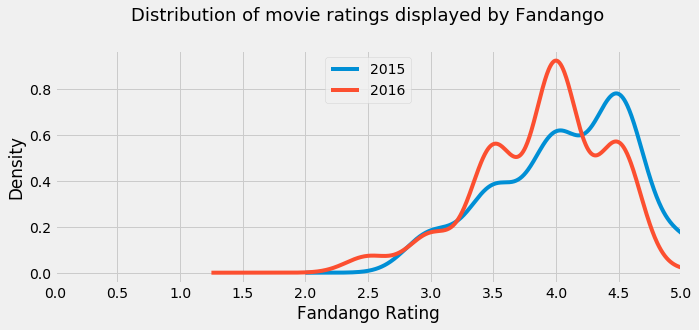

In [10]:
# Use the fivethirtyeight style. Must be set before plotting. Will apply to all future plots.
plt.style.use('fivethirtyeight')

# Use kernel density estimate plots, add legend labels, and choose plot size.
inflated_f15['Fandango_Stars'].plot.kde(label=2015, figsize=(10,4))
new_f16['fandango'].plot.kde(label=2016)

# Add a title, englarge font size, and shift slightly up.
plt.title('Distribution of movie ratings displayed by Fandango', fontdict={'fontsize':18}, y=1.1)

# Add axis labels.
plt.xlabel('Fandango Rating')

# Display x-axis from 0 to 5 as that's the span of Fandango's ratings.
plt.xlim(0,5)

# Set ticks of x-axis.
plt.xticks(arange(0,5.5,0.5))

# Show legend.
plt.legend(loc='upper center')

# Display graph.
plt.show()

We can see in the plot above the that there is a marked differed between the two years. The 2015 ratings distribution is left-skewed with a peak around a 4.5 rating while the 2016 data is still left skewed but less so, and has a peak around a 4.0 rating.

---

### Frequency Table
Let's explore the frequency tables of the two distributions. The data sets have different numbers of movies so we'll compare relative frequencies instead of absolute frequencies. We'll use percentages rather than proportions because they're easier to read and tend to be more intuitive.

In [11]:
# Percent frequencies of 2015 scores.
freq15 = 100*inflated_f15['Fandango_Stars'].value_counts(normalize=True).sort_index()

# Percent frequencies of 2016 scores.
freq16 = 100*new_f16['fandango'].value_counts(normalize=True).sort_index()

# Create a dataframe of relative score frequencies by percentages.
score_freq = pd.DataFrame(arange(0,5.5,.5), columns=['Score'])

# Add columns to new dataframe with score frequency data.
score_freq = score_freq.merge(freq15, 'left', left_on='Score', right_index=True)
score_freq = score_freq.merge(freq16, 'left', left_on='Score', right_index=True)

# Change NaNs to 0s.
score_freq.fillna(0, inplace=True)

# Change column names.
score_freq.columns = ['Score', '2015 frequency %', '2016 frequency %']

# Return the frequency table with percentages rounded to one decimal place.
round(score_freq,1)

,Score,2015 frequency %,2016 frequency %
0,0.0,0.0,0.0
1,0.5,0.0,0.0
2,1.0,0.0,0.0
3,1.5,0.0,0.0
4,2.0,0.0,0.0
5,2.5,0.0,3.1
6,3.0,8.5,7.3
7,3.5,17.8,24.1
8,4.0,28.7,40.3
9,4.5,38.0,24.6


The frequency table also shows a clear difference in ratings between the two years. In 2015, there weren't any ratings below 3 stars. In 2016 the lowest ratings went down to 2.5 stars. The most frequent 2015 rating (38%) was 4.5 while 2016's (40%) was 4.0 (which reflects what we saw in the density plot above).

---

### Summary Statistics

In [12]:
# Create a dictionary with the summary statistics.
sum_stats_dict = {
    'mean': [inflated_f15['Fandango_Stars'].mean(), new_f16['fandango'].mean()],
    'median': [inflated_f15['Fandango_Stars'].median(), new_f16['fandango'].median()],
    'mode': [inflated_f15['Fandango_Stars'].mode()[0], new_f16['fandango'].mode()[0]] #mode.() output returns more than just mode.
}

# Create a dataframe from the dictionary.
sum_stats = pd.DataFrame.from_dict(sum_stats_dict, orient ='index')

# Add column names.
sum_stats.rename(columns={0:'2015', 1:'2016'}, inplace=True)
round(sum_stats,2)

,2015,2016
mean,4.09,3.89
median,4.00,4.00
mode,4.50,4.00


In [13]:
# Print difference between the means rounded to 3 places.
print("The difference between the means is",round(inflated_f15['Fandango_Stars'].mean()-new_f16['fandango'].mean(),3),".")

# Print percent drop between the means rounded to 3 places.
print("The percentage drop between the means is",100*round((inflated_f15['Fandango_Stars'].mean()-new_f16['fandango'].mean())/inflated_f15['Fandango_Stars'].mean(),3),"%.")

The difference between the means is 0.198 .
The percentage drop between the means is 4.8 %.


From the summary statistics we can see a clear shift towards lower scores from 2015 to 2016. Both the mean and the mode decreased showing that the average of all the scores as well as the most frequent scores went down. The average score went down by 0.2, or less than a quarter of a star. This represents less than a 5% decrease. The most frequent score went from being 4.5 stars in 2015 to 4.0 in 2016 as we saw in our density plot above.

#### Visualizing summary statistics

In [14]:
# Import seaborn library for plotting.
import seaborn as sns

In [23]:
# Create a dataframe for bar plotting summary statistics.

# Create dataframes of statistics for both years to concatenate.
stats15 = sum_stats.copy()
stats15['year'] = 2015
stats15.drop(columns='2016', inplace=True)

stats16 = sum_stats.copy()
stats16['year'] = 2016
stats16.drop(columns='2015', inplace=True)

# Rename columns to be able to concatenate.
stats15.rename(columns={'2015':'Stars'}, inplace=True)
stats16.rename(columns={'2016':'Stars'}, inplace=True)

# Concatenate the dataframe and display the result.
stats_plot = pd.concat([stats15, stats16])
round(stats_plot,2)

,Stars,year
mean,4.09,2015
median,4.00,2015
mode,4.50,2015
mean,3.89,2016
median,4.00,2016
mode,4.00,2016


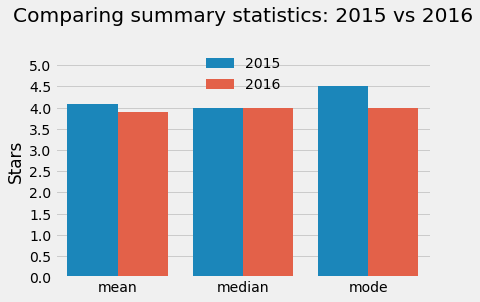

In [16]:
# Create a grouped bar plot with x=stats, y=stat values, hue=years.
sns.barplot(x=stats_plot.index, y='Stars', hue='year', data=stats_plot)
plt.legend(loc='upper center', framealpha=0)
plt.title('Comparing summary statistics: 2015 vs 2016', y=1.07)
plt.ylim(0, 5.5)
plt.yticks(arange(0,5.1,.5))
plt.show()

Using bars to visualize our summary statistics makes it clear that the scores shifted towards lower values from 2015 to 2016. The mean went down slightly and the median remained the same, while the mode went down by half a star.

---

## Conclusion

We witnessed a clear difference between Fandango's score values in 2015 and in 2016. There was a general shift towards lower scores with a lowering of the average score and of the most common score. The mode of these two data sets notably went down by half a star. Hickey's analysis found that scores were most frequently rounded up by half a star. It's therefore possible that Fandango adjusted their code to eliminate the bug (or feature) that was erroneously inflating scores by half a star.

---

# What about other movie review sites?

It would be interesting to explore what happened in this same time frame with other similar sites to put our findings into context. We've already got the data for three other major movie review sites: Rotten Tomatoes, MetaCritic, and IMDB.

Let's begin by reaquainting ourselves with the data.

In [17]:
inflated.head(2)

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,Metacritic_norm,Metacritic_user_nom,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,3.30,3.55,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,3.35,3.75,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5


In [18]:
new.head(2)

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.8,3.60,4.5,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.4,3.65,2.5,4.15,2.5,3.5,2.5,4.0


We would like to know: how did score behavior change between 2015 and 2016 for these three other major movie review sites, and how does that behavior compare with the change in Fandango's scores? We want our data to be as comparable as possible, so we'll limit our analysis to the same years as before and to the user rather than the critic scores when applicable and available. Luckily both datasets have already normalized the scores from the other sites to Fandango's 0-5 scale and rounded to a half-star as Fandango did.

In [19]:
# Add year column for easy filtering.
inflated['year'] = inflated['FILM'].str.extract(r'(\d\d\d\d)')

# Filter pre-analysis data for 2015 films.
inflated15 = inflated[inflated['year']=='2015'].copy()

# Filter post-analysis data for 2016 films.
new16 = new[new['year']==2016]

# Filter for only columns of interest.
norm2015 = inflated15[['FILM', 'Fandango_Stars', 'RT_user_norm_round', 'IMDB_norm_round', 'Metacritic_norm_round']]
norm2016 = new16[['movie', 'fandango', 'nr_audience', 'nr_imdb', 'nr_metascore']]

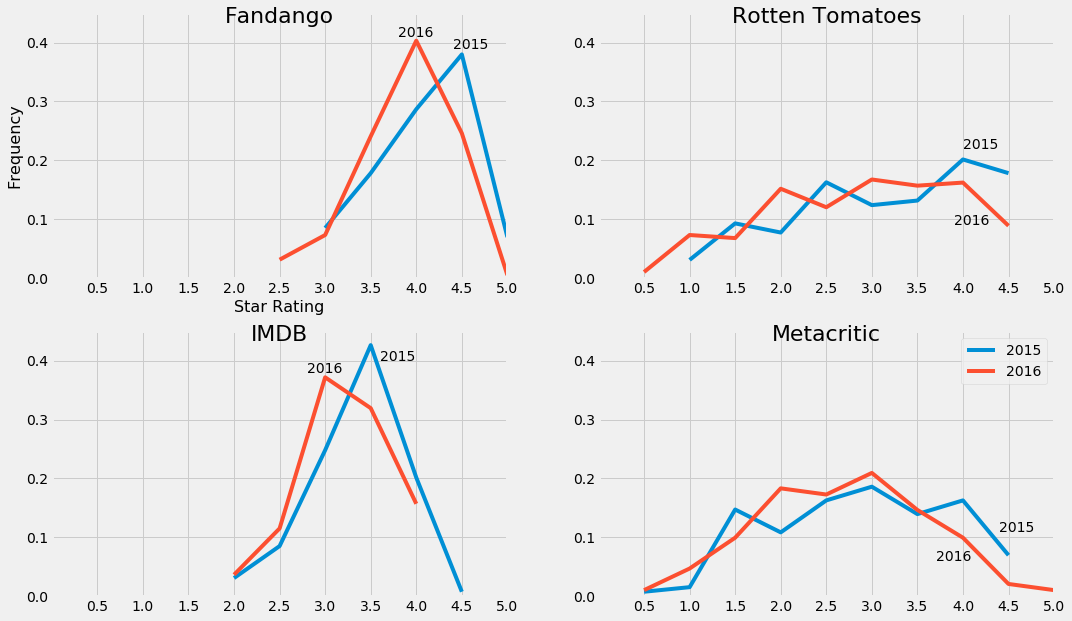

In [62]:
# Create list of subplot titles.
sites = ['Fandango', 'Rotten Tomatoes', 'IMDB', 'Metacritic']

# Create line subplots of all 4 sites' frequency distributions.
fig = plt.figure(figsize=(16,10))
for i in range(0,4):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(norm2015[norm2015.columns[i+1]].value_counts(normalize=True).sort_index(), label=2015)
    ax.plot(norm2016[norm2016.columns[i+1]].value_counts(normalize=True).sort_index(), label=2016)
    
    # Add subplot titles.
    ax.set_title(sites[i], fontdict={'fontsize':22}, y=.94)
    
    # Set axis limits.
    ax.set_xlim(0,5)
    ax.set_ylim(0,0.45)
    
    # Set axis tick marks.
    ax.set_xticks(arange(0.5,5.1,.5))
    ax.set_xticklabels(arange(0.5,5.1,.5))
    ax.set_yticks(arange(0,.41,.1))
    
    # Set axis labels on first plot only.
    if i==0:
        ax.set_xlabel('Star Rating', fontdict={'fontsize':16})
        ax.set_ylabel('Frequency', fontdict={'fontsize':16})
    
    # Add individual line labels.
    if i==0:
        ax.text(4.4,.39,'2015')
        ax.text(3.8, .41, '2016')
    elif i==1:
        ax.text(4.0,.22,'2015')
        ax.text(3.9, .09, '2016')
    elif i==2:
        ax.text(3.6,.4,'2015')
        ax.text(2.8, .38, '2016')
    elif i==3:
        ax.text(4.4,.11,'2015')
        ax.text(3.7, .06, '2016')

# Add legend, only applies to last plot.
plt.legend(loc='upper right')

# Display the plots.
plt.show()

The distributions of normalized scores in the plots above show somewhat similar trends. Fandango's and IMDB's user scores are left-skewed with sharp peaks. Fandango's scores' peaks are a full star higher than IMDB's for both years. Rotten Tomatoes' user scores are also left-skewed but with one long, gentle slope and no sharp peaks. It looks like RT's scores may have decreased, but it isn't immediately obvious from the plot. Metacritic's critics score distribution is the only one to resemble a normal distribution. As with RT's, it's difficult to tell from the plot how the scores changed from one year to another.

Let's look towards summary statistics to fill in information we didn't get from the plots.

In [21]:
# Create tables of means for the 2015 and 2016 data and add website names column for indexing.
means15 = pd.DataFrame(norm2015.describe().loc['mean'])
means15.rename(columns={'mean':'2015'}, inplace=True)
means15['sites'] = sites

means16 = pd.DataFrame(norm2016.describe().loc['mean'])
means16.rename(columns={'mean':'2016'}, inplace=True)
means16['sites'] = sites

# Merge tables on site names column, and drop site names column.
means = means15.merge(means16, how='inner', on='sites')
means.set_index(means['sites'], inplace=True)
means.drop(columns=['sites'], inplace=True)

# Calculate the change in mean for each website.
means['change'] = means['2016']-means['2015']

# Display table of means rounded to two decimal places, and sort by magnitude of change.
round(means,2).sort_values('change')

,2015,2016,change
sites,,,
Rotten Tomatoes,3.17,2.89,-0.29
Fandango,4.09,3.89,-0.20
Metacritic,2.88,2.69,-0.19
IMDB,3.35,3.22,-0.13


While Fandango's scores are on average higher than the other three movie review sites, its change in average from one year to another is well within the range of changes for the other sites. This indicates that movies in 2016 were on the whole rated lower than those in 2015 and that the drop in Fandango's average scores may not at all be related to a change in their coding.

Let's take a look at the modes and compare them.

In [22]:
# Calculate the modes for both years and all four websites.
modes15 = norm2015[['Fandango_Stars', 'RT_user_norm_round', 'IMDB_norm_round', 'Metacritic_norm_round']].mode()
modes16 = norm2016[['fandango', 'nr_audience', 'nr_imdb', 'nr_metascore']].mode()

# Transpose from row of modes to columns.
modes15 = modes15.transpose()
modes16 = modes16.transpose()

# Name columns.
modes15.rename(columns={0:'2015'}, inplace=True)
modes16.rename(columns={0:'2016'}, inplace=True)

# Add website column for indexing.
modes15['sites'] = sites
modes16['sites'] = sites

# Merge tables on site names column, and drop site names column.
modes = modes15.merge(modes16, how='inner', on='sites')
modes.set_index(modes['sites'], inplace=True)
modes.drop(columns=['sites'], inplace=True)

# Calculate the change in mode for each website.
modes['change'] = modes['2016']-modes['2015']

# Display table of modes and sort by magnitude of change.
modes.sort_values('change')

,2015,2016,change
sites,,,
Rotten Tomatoes,4.0,3.0,-1.0
Fandango,4.5,4.0,-0.5
IMDB,3.5,3.0,-0.5
Metacritic,3.0,3.0,0.0


After calculating the modes for all four websites' ratings in 2015 and 2016, we see that Fandango's change in score again falls right in the middle of the range.

---

## Conclusion

Fandango is the only one of the four main movie review sites that sells tickets, and as such, they're the only one to directly benefit from inflated ratings. Seeing the drop in Fandango's movie ratings from 2015 to 2016 made it seem reasonable to believe that their system had changed after Hickey's article about Fandango's inflated ratings. Calculating the change in scores for the other three sites provided the context that perhaps 2016 was just a less enjoyable movie year than 2015. Since Fandango's scores didn't decrease considerably more than IMDB's or Metacritic's, and in fact decreased less than the ratings on Rotten Tomatoes, it doesn't seem likely that there was any change in Fandango's system between these two years.  Perhaps in an effort to distance itself from its past issues with ratings, Fandango now (as of 2020) only displays ratings from Rotten Tomatoes.

#### Further Considerations

Knowing that Fandango's ratings weren't reliable begs the question - which movie review site is the most accurate? From our brief exploration, Metacritic would be a front runner since its scores had the most normal (Gaussian) distribution. It would be worth exploring this question in more depth as being able to determine verity of ratings would have wide ranging applications. 

We could also analyze Fandango ticket sales before and after the switch from displaying their own ratings to RT's. This could give us an idea of the impact that inflated ratings had on ticket sales.